# Tutorial on Language Models

Will be working with N-gram models (which are a statistical, not neural net, approach to language modelling). I'll follow:

https://medium.com/swlh/language-modelling-with-nltk-20eac7e70853

Language model: a probability distribution over sets of words (or sentences, paragraphs, etc). At least, this is very much the case for statistical language models---not yet clear to me if neural network-based models fit into this picture neatly.

For simplicity (and to ease the computational complexity of the problem), we constrain our space of probability distributions to *Markovian* distributions, i.e. the probability of a word conditional on whatever came before only depends on the previous word. 

If we didn't erase "stopwords", then the Markov assumption would collapse the model (in many situations, at least) to a model of relative frequencies of words restricted to particular parts of speech. E.g. in "... the X ...", the distribution p(X | everything before) = p(X|the). I guess that, pretty much, the only thing that makes sense is to set p(X|the)=0 for all X which are a part of speech that wouldn't make sense here (e.g. a verb I guess), and otherwise p(X|the)=(renormalized) frequency of X in the training text. 

On the other hand, if we erase stop words, we can get a more 'informative' predecessor to X, and have a non-trivial distribution.

In [1]:
import nltk, re, pprint, string
from nltk import word_tokenize, sent_tokenize
from urllib import request

string.punctuation = string.punctuation +'“'+'”'+'-'+'’'+'‘'+'—'
string.punctuation = string.punctuation.replace('.', '')

file = open('data/book1.txt', encoding = 'utf8').read()

url = "https://www.gutenberg.org/cache/epub/68283/pg68283.txt"
response = request.urlopen(url)
cthulu_raw = response.read().decode('utf8')
cthulu = nltk.Text(cthulu_raw)

The period was removed from punctuation in order to be able to count sentences (i.e. we won't remove periods from the text).

In [2]:
#preprocess data
file_nl_removed = ""
for line in file:
  line_nl_removed = (
    line.replace("\n", " ").replace("  ", " ")      
    ) #removes newlines and double space
  file_nl_removed += line_nl_removed
file_p = "".join(
  [char for char in file_nl_removed if char not in string.punctuation]
)   #removes all special characters

In [3]:
# some basic statistics about the text
def basic_stats(file_obj_or_str):
    sents = nltk.sent_tokenize(file_obj_or_str)
    print("The number of sentences is", len(sents)) 
    #prints the number of sentences
    words = nltk.word_tokenize(file_obj_or_str)
    print("The number of tokens is", len(words)) 
    #prints the number of tokens
    average_tokens = round(len(words)/len(sents))
    print("The average number of tokens per sentence is",
    average_tokens) 
    #prints the average number of tokens per sentence
    unique_tokens = set(words)
    print("The number of unique tokens are", len(unique_tokens)) 
    return words, sents
    #prints the number of unique tokens

In [4]:
words, sents = basic_stats(file_p)

The number of sentences is 4335
The number of tokens is 93364
The average number of tokens per sentence is 22
The number of unique tokens are 6486


## N-gram business

Now we start creating the necessary parts for an N-gram model for some values of N.

In [13]:
from nltk.util import ngrams
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def generate_ngrams(sentences, n):
    # sents = sentence-tokenized text (pretty much, list of sentences)
    # n = order of the ngrams (e.g. 2 for bigrams)

    tokenized_text =[
        word_tokenize(sentence.lower())[:-1] 
        if sentence[-1]=='.'
        else word_tokenize(sentence.lower())
        for sentence in sentences
    ]

    ngram_list =  [
        pair for sequence in tokenized_text for pair in list(ngrams(sequence, n)) 
    ] 


    return ngram_list

def removal(x):     
#removes ngrams containing only stopwords
    y = []
    for pair in x:
        count = 0
        for word in pair:
            if word not in stop_words:
                count = count or 1
        if (count==1):
            y.append(pair)
    return y

def ngram_stats(sentences, n_list):
    freqs_dict = {}
    for n in n_list:
        ngram_list = removal(generate_ngrams(sentences, n)) # [0] needed cause otherwise it's one list per n
        # print(ngram_list)
        freq_n = nltk.FreqDist(ngram_list)
        freqs_dict[n] = freq_n
        print(f"""
        Most common {n}-grams: {[(list(x),y) for (x,y) in freq_n.most_common(5)]}
        """)
    return freqs_dict
    

ngram_stats(sents, [2, 3, 4])





        Most common 2-grams: [(['the', 'old'], 272), (['said', 'polly'], 226), (['the', 'little'], 218), (['going', 'to'], 190), (['mrs.', 'pepper'], 156)]
        

        Most common 3-grams: [(['o', 'dear', 'me'], 88), (['im', 'going', 'to'], 66), (['said', 'mrs.', 'pepper'], 55), (['on', 'the', 'floor'], 45), (['little', 'brown', 'house'], 42)]
        

        Most common 4-grams: [(['the', 'little', 'brown', 'house'], 35), (['the', 'middle', 'of', 'the'], 29), (['the', 'side', 'of', 'the'], 25), (['the', 'little', 'white', 'cat'], 20), (['o', 'dear', 'me', 'exclaimed'], 16)]
        


{2: FreqDist({('the', 'old'): 272, ('said', 'polly'): 226, ('the', 'little'): 218, ('going', 'to'): 190, ('mrs.', 'pepper'): 156, ('dear', 'me'): 109, ('to', 'get'): 106, ('o', 'dear'): 103, ('said', 'mrs.'): 95, ('said', 'the'): 95, ...}),
 3: FreqDist({('o', 'dear', 'me'): 88, ('im', 'going', 'to'): 66, ('said', 'mrs.', 'pepper'): 55, ('on', 'the', 'floor'): 45, ('little', 'brown', 'house'): 42, ('the', 'little', 'brown'): 38, ('the', 'old', 'kitchen'): 36, ('the', 'little', 'doctor'): 34, ('old', 'mr.', 'beebe'): 33, ('side', 'of', 'the'): 33, ...}),
 4: FreqDist({('the', 'little', 'brown', 'house'): 35, ('the', 'middle', 'of', 'the'): 29, ('the', 'side', 'of', 'the'): 25, ('the', 'little', 'white', 'cat'): 20, ('o', 'dear', 'me', 'exclaimed'): 16, ('in', 'the', 'middle', 'of'): 15, ('i', 'dont', 'want', 'to'): 15, ('said', 'polly', 'with', 'a'): 15, ('said', 'old', 'mr.', 'beebe'): 13, ('the', 'project', 'gutenberg', 'literary'): 13, ...})}

In [6]:
print(len(sents))


4335


In [75]:
old_code_hehe = """
# same functionality as above, but more 'for loopy', this was the code
# provided in the tutorial

unigram=[]
# bigram=[]
# trigram=[]
# fourgram=[]
tokenized_text = []

# create 'raw' list of unigrams, bigrams, etc. Do this by:
# 1. separating into sentences (already done, list is sents)
# 2. word-tokenizing sentences
# 3. removing periods as tokens (I already have sentences separated anyhow)
# 4. extend the list of N-grams (for each N) by all N-grams in each sentence

for sentence in sents:
    sentence = sentence.lower()
    sequence = word_tokenize(sentence) 
    for word in sequence:
        if (word =='.'):
            sequence.remove(word) 
        else:
            unigram.append(word)
    tokenized_text.append(sequence) 
    # list of lists, where each sublist is a sentence
    bigram.extend(list(ngrams(sequence, 2)))
    #trigram.extend(list(ngrams(sequence, 3)))
    #fourgram.extend(list(ngrams(sequence, 4)))
    #unigram, bigram, trigram, and fourgram models are created


def removal(x):     
#removes ngrams containing only stopwords
    y = []
    for pair in x:
        count = 0
        for word in pair:
            if word not in stop_words:
                count = count or 1
        if (count==1):
            y.append(pair)
    return y

# remove purely-stopword N-grams
bigram = removal(bigram)
#trigram = removal(trigram)             
#fourgram = removal(fourgram)

# get freq distributions
freq_bi = nltk.FreqDist(bigram)
#freq_tri = nltk.FreqDist(trigram)
#freq_four = nltk.FreqDist(fourgram)

print(bigram[:10])
print(freq_bi)

# print out results
print(
    "Most common n-grams without stopword removal and without add-1 smoothing:"
)
print(" ")
print ("Most common bigrams: ", freq_bi.most_common(5))
# print ("\nMost common trigrams: ", freq_tri.most_common(5))
# print ("\nMost common fourgrams: ", freq_four.most_common(5))
"""

# N-grams for Lovecraft

In [69]:
url_list = [
    "https://www.gutenberg.org/cache/epub/68283/pg68283.txt",
    "https://www.gutenberg.org/cache/epub/50133/pg50133.txt",
    "https://www.gutenberg.org/cache/epub/68236/pg68236.txt",
    "https://www.gutenberg.org/cache/epub/68553/pg68553.txt",
    "https://www.gutenberg.org/cache/epub/70486/pg70486.txt",
    "https://www.gutenberg.org/cache/epub/31469/pg31469.txt",
    "https://www.gutenberg.org/cache/epub/68547/pg68547.txt",
]

stories_raw = [
    request.urlopen(url).read().decode('utf8') for url in url_list
]


In [70]:
import re

def rmv_bracket_text(s: str):
    in_brackets = re.findall(r'\[.*?\]', s)
    for brck_txt in in_brackets:
        s = s.replace(brck_txt, '')
    print(s[:100])
    return s
    
# print(rmv_bracket_text("a"))

In [71]:


def preprocess(s):
    to_erase = [ch for ch in string.punctuation if ch not in ['.', '[', ']']]
    to_erase = [
        *to_erase, 
        '“', '”', '-', '’', '‘', '—', 
        '\r', '\ufeff', 
        'ebook', 'the project gutenberg', 'project gutenberg',
        'electronic', 'by h.p. lovecraft', 'by h. p. lovecraft',
    ]
    
    start_marker = "*** START OF".lower()
    end_marker = "*** END OF".lower()
    
    start_marker_start = s.find(start_marker)
    
    story_start = s[
        start_marker_start
        +3: ].find("***") + start_marker_start
    story_end = s.find(end_marker)
    print(f"marker start = {start_marker_start}")
    print(f"start = {story_start}")
    print(f"end = {story_end}")
    
    
    
    s = s[
        story_start+3: 
        story_end
    ]
    
    for x in to_erase:
        s = s.replace(x, "")
    s = s.replace("\n", " ")
    
    return s

stories = [
    rmv_bracket_text(
        preprocess(
            story.lower()
        )
    ) for story in stories_raw
]
data = " ".join(stories)

# # that's the first sentence in the story
# cthulu_raw = cthulu_raw[
#     cthulu_raw.find(start_marker):cthulu_raw.find(end_marker)
# ] # dont include all the blah blah about project gutenberg

sentences = nltk.sent_tokenize(data)
# print(sents)
freq_d = ngram_stats(sentences, [1, 2, 3, 4, 5])

marker start = 774
start = 832
end = 73278
      the call of cthulhu           of such great powers or beings there may be conceivably a     su
marker start = 652
start = 710
end = 104078
     produced by greg weeks mary meehan and the online distributed proofreading team at httpwww.pgdp
marker start = 781
start = 843
end = 72012
                              the colour out of space                                               
marker start = 665
start = 716
end = 21755
       the festival    author of dagon the rats in the walls etc.       efficiunt daemones ut quae n
marker start = 808
start = 863
end = 50336
                                 the lurking fear                                                   
marker start = 463
start = 520
end = 65890
     produced by greg weeks stephen blundell and the online distributed proofreading team at httpwww
marker start = 645
start = 686
end = 25541
      he        i saw him on a sleepless night when i was walking desperately to save my sou

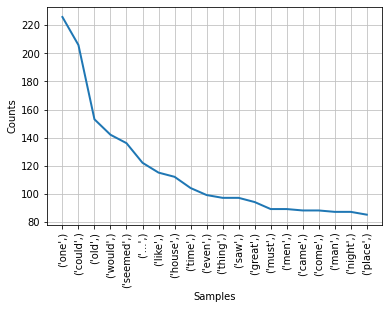

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [80]:
freq_d[1].plot(20)

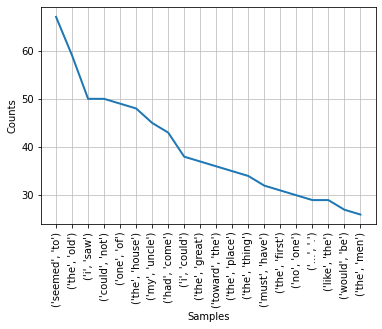

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [81]:
freq_d[2].plot(20)

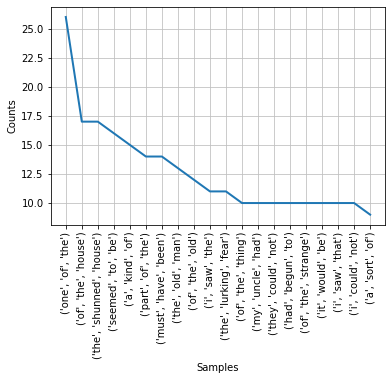

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [78]:
freq_d[3].plot(20)

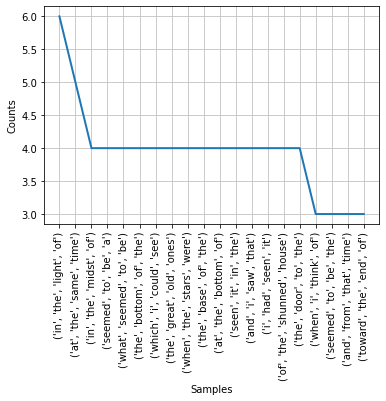

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [79]:
freq_d[4].plot(20)